# Tools and Data

## Reading and dependencies

In [1]:
import json
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math

from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Enable inline plotting
%matplotlib inline

# Seaborn style
sns.set(style="whitegrid")

### JSON parsing

In [2]:
# Function to flatten one JSON object into a flat dictionary
def flatten_json(jdata):
    flat = {}
    for k, v in jdata.get('metadata', {}).items():
        flat[f'{k}'] = v
    for k, v in jdata.get('best_solution', {}).items():
        flat[f'best_solution_{k}'] = v
    for metric, values in jdata.get('raw_metrics', {}).items():
        flat[f'{metric}'] = values
    return flat

def load_df(data_dir):
    json_files = glob.glob(os.path.join(data_dir, "*.json"))
    records = []
    for f in json_files:
        with open(f, 'r') as infile:
            try:
                data = json.load(infile)
                flat_data = flatten_json(data)
                records.append(flat_data)
            except Exception as e:
                print(f"Error reading {f}: {e}")
    # Create a pandas DataFrame from the flattened data
    return pd.DataFrame(records)

### JSON File Reading

In [3]:
gpu_effort = load_df("data/gpu-11_27pm")
gpu = load_df("data/gpu-11_50am")
cpuseq = load_df("data/cpu_seq")
cpupar = load_df("data/cpu_par")

dfs = {
    'gpu_effort': gpu_effort,
    'gpu': gpu,
    'cpuseq': cpuseq,
    'cpupar': cpupar
}

for k in dfs.keys():
    print(k)
    print(dfs[k].dtypes)
    print('='*30)


gpu_effort
datetime                object
problem                 object
solver                  object
n                        int64
executions               int64
cutoff                 float64
hit_percent            float64
machine                 object
best_solution_route     object
best_solution_cost     float64
best_solution_idx        int64
costs                   object
seconds                 object
cycles                  object
iterations              object
dtype: object
gpu
datetime                object
problem                 object
solver                  object
n                        int64
executions               int64
cutoff                 float64
hit_percent            float64
machine                 object
best_solution_route     object
best_solution_cost     float64
best_solution_idx        int64
costs                   object
seconds                 object
cycles                  object
iterations              object
dtype: object
cpuseq
datetime            

### Plot Caching

In [4]:
# To store and reuse plots later on
import io
from IPython.display import display
from PIL import Image

plot_cache = dict()
def save_plt(name):
    if name in plot_cache:
        del plot_cache[name]
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plot_cache[name] = buf
    plt.close()

def display_saved_plt(name):
    if name not in plot_cache:
        raise Exception("Plot not cached")
    display(Image.open(plot_cache[name]))

def cached_mosaic(names, dims):
    imgs = list()
    for idx, name in enumerate(names):
        if name in plot_cache:
            img_data = plot_cache[name]
            img = Image.open(img_data)
            imgs.append(img)
    rows, cols = dims
    img_w, img_h = imgs[0].size
    mosaic = Image.new("RGB", (cols*img_w, rows*img_h))

    for i, img in enumerate(imgs):
        x_off = (i%cols) * img_w
        y_off = (i//cols) * img_h
        mosaic.paste(img, (x_off, y_off))

    display(mosaic)

## GPU executions of 10,000 iterations with cutoff at maximum effort

In [5]:
gpu_effort.sort_values('n')

,datetime,problem,solver,n,executions,cutoff,hit_percent,machine,best_solution_route,best_solution_cost,best_solution_idx,costs,seconds,cycles,iterations
0,2025-05-13T12_32_03.224Z,berlin52,GPU Parallel Genetic Solver,52,30,0.0,0.0,WallE,"[41, 8, 9, 10, 43, 33, 51, 11, 52, 14, 13, 47,...",7544.365,0,"[7544.365, 7544.365, 7544.365, 7954.068, 7544....","[8.835418, 8.820323, 8.776111, 8.735415, 8.790...","[32710375818, 32654494142, 32490812555, 323401...","[10000, 10000, 10000, 10000, 10000, 10000, 100..."
1,2025-05-13T12_42_54.585Z,kroB100,GPU Parallel Genetic Solver,100,30,0.0,0.0,WallE,"[14, 42, 2, 16, 50, 43, 89, 87, 66, 74, 60, 57...",22139.070,7,"[22623.0, 22363.0, 22239.2, 22773.72, 22991.71...","[19.96039, 19.92849, 19.93898, 19.99248, 19.89...","[73897114633, 73779019439, 73817870332, 740159...","[10000, 10000, 10000, 10000, 10000, 10000, 100..."
2,2025-05-13T12_54_32.252Z,lin105,GPU Parallel Genetic Solver,105,30,0.0,0.0,WallE,"[78, 71, 68, 67, 64, 72, 77, 79, 86, 80, 76, 7...",14382.990,3,"[14406.12, 14429.07, 15221.34, 14382.99, 14558...","[21.27144, 21.28132, 21.31066, 21.30489, 21.35...","[78750857230, 78787430086, 78896088222, 788746...","[10000, 10000, 10000, 10000, 10000, 10000, 100..."
3,2025-05-13T13_23_33.844Z,tsp225,GPU Parallel Genetic Solver,225,30,0.0,0.0,WallE,"[11, 12, 13, 14, 15, 16, 17, 18, 19, 203, 20, ...",3959.134,26,"[4036.104, 4110.193, 4126.151, 4065.023, 4092....","[52.9069, 53.07233, 52.95756, 52.90204, 53.099...","[195871287905, 196483742536, 196058873598, 195...","[10000, 10000, 10000, 10000, 10000, 10000, 100..."
4,2025-05-13T14_28_52.738Z,pcb442,GPU Parallel Genetic Solver,442,30,0.0,0.0,WallE,"[357, 356, 434, 355, 354, 353, 316, 317, 318, ...",53226.530,2,"[53427.54, 54335.02, 53226.53, 53767.54, 54387...","[117.879, 116.9153, 117.1515, 116.9643, 117.00...","[444491953916, 440858068138, 441748775912, 441...","[10000, 10000, 10000, 10000, 10000, 10000, 100..."
5,2025-05-13T16_13_39.196Z,d657,GPU Parallel Genetic Solver,657,30,0.0,0.0,WallE,"[461, 462, 466, 468, 471, 52, 48, 62, 67, 59, ...",52386.000,23,"[52934.08, 52881.38, 52861.38, 53154.74, 53123...","[188.2091, 188.0445, 188.1892, 188.0905, 188.1...","[709688948094, 709068364882, 709613896664, 709...","[10000, 10000, 10000, 10000, 10000, 10000, 100..."
6,2025-05-13T18_22_15.729Z,rat783,GPU Parallel Genetic Solver,783,30,0.0,0.0,WallE,"[135, 122, 119, 113, 104, 131, 132, 141, 130, ...",9865.462,3,"[10537.88, 10132.97, 10035.25, 9865.462, 10113...","[230.8805, 230.7313, 230.8479, 230.5477, 230.8...","[870591991700, 870029151664, 870469159784, 869...","[10000, 10000, 10000, 10000, 10000, 10000, 100..."
7,2025-05-13T21_54_41.701Z,pcb1173,GPU Parallel Genetic Solver,1173,30,0.0,0.0,WallE,"[851, 846, 834, 784, 777, 825, 847, 848, 849, ...",108797.600,14,"[120138.4, 123222.3, 120592.6, 118822.8, 12526...","[381.3394, 381.2783, 381.4434, 381.4842, 381.3...","[1437934552504, 1437704021100, 1438326573014, ...","[10000, 10000, 10000, 10000, 10000, 10000, 100..."


## GPU executions of 10,000 iterations with cutoff at target cost or maximum effort

In [6]:
gpu.sort_values('n')

,datetime,problem,solver,n,executions,cutoff,hit_percent,machine,best_solution_route,best_solution_cost,best_solution_idx,costs,seconds,cycles,iterations
0,2025-05-11T22_19_34.883Z,berlin52,GPU Parallel Genetic Solver,52,50,7843.68,0.82,WallE,"[27, 28, 12, 25, 4, 6, 15, 5, 24, 48, 46, 37, ...",7621.701,4,"[7887.226, 7841.811, 7840.756, 7813.521, 7621....","[219.9957, 0.1369323, 0.1822764, 0.1326012, 0....","[814465621055, 506943978, 674820167, 490912293...","[250000, 141, 191, 135, 178, 116, 108, 172, 14..."
1,2025-05-11T22_20_49.825Z,kroB100,GPU Parallel Genetic Solver,100,50,23248.05,1.00,WallE,"[40, 39, 70, 53, 73, 85, 93, 11, 3, 28, 91, 97...",23054.690,22,"[23187.97, 23232.35, 23186.22, 23112.68, 23239...","[0.9255996, 1.00016, 0.8809739, 1.255852, 0.94...","[3426741068, 3702778926, 3261529899, 464939815...","[445, 484, 420, 608, 455, 417, 482, 423, 501, ..."
2,2025-05-11T22_24_17.022Z,lin105,GPU Parallel Genetic Solver,105,50,15097.95,1.00,WallE,"[88, 94, 95, 100, 99, 98, 93, 101, 102, 97, 96...",14736.310,22,"[15066.3, 15089.53, 15046.31, 15084.35, 15079....","[1.162428, 1.067089, 1.09791, 0.9643656, 1.970...","[4303524194, 3950561398, 4064667079, 357026101...","[524, 483, 496, 435, 909, 641, 489, 588, 412, ..."
3,2025-05-11T22_33_28.013Z,tsp225,GPU Parallel Genetic Solver,225,50,4193.33,1.00,WallE,"[11, 10, 9, 8, 7, 6, 5, 4, 3, 1, 200, 198, 197...",4166.302,10,"[4190.186, 4192.847, 4191.687, 4184.866, 4185....","[7.38594, 9.753932, 9.30713, 9.862912, 8.16254...","[27344135816, 36110889168, 34456743504, 365143...","[1356, 1802, 1719, 1825, 1506, 1772, 1773, 161..."
4,2025-05-12T00_12_41.166Z,pcb442,GPU Parallel Genetic Solver,442,50,54840.24,1.00,WallE,"[12, 13, 14, 47, 79, 100, 80, 48, 15, 16, 17, ...",54691.970,23,"[54785.95, 54766.69, 54836.12, 54807.82, 54822...","[84.44571, 71.97059, 102.545, 64.98933, 65.740...","[312633914682, 266448657208, 379640702273, 240...","[7058, 5984, 8542, 5387, 5447, 6701, 6459, 732..."
5,2025-05-12T03_11_17.527Z,d657,GPU Parallel Genetic Solver,657,50,53314.08,1.00,WallE,"[122, 106, 105, 91, 71, 59, 67, 72, 81, 82, 76...",53150.820,40,"[53292.68, 53300.83, 53311.63, 53302.0, 53311....","[246.321, 157.5343, 197.0602, 192.1078, 178.33...","[928814204752, 594022035198, 743064247744, 724...","[13082, 8334, 10445, 10193, 9439, 10040, 13458..."
6,2025-05-12T09_15_28.389Z,rat783,GPU Parallel Genetic Solver,783,50,9598.54,1.00,WallE,"[461, 479, 481, 471, 478, 468, 465, 475, 488, ...",9588.249,2,"[9596.516, 9598.447, 9588.249, 9590.911, 9598....","[400.9437, 449.0737, 359.8752, 410.203, 379.59...","[1511857052554, 1693343110964, 1356998191340, ...","[17373, 19476, 15629, 17780, 16450, 16553, 252..."
7,2025-05-13T11_38_30.309Z,pcb1173,GPU Parallel Genetic Solver,1173,50,62581.20,0.98,WallE,"[244, 243, 245, 246, 248, 247, 219, 236, 235, ...",62503.390,15,"[62570.29, 62560.09, 62570.52, 62553.38, 62580...","[1218.816, 1021.09, 1098.758, 1251.291, 1490.2...","[4595845961156, 3850272554552, 4143138991780, ...","[32236, 26943, 28934, 33143, 39503, 28489, 390..."


## Sequential CPU executions of 10,000 iterations with cutoff at target cost or maximum effort

In [7]:
cpuseq.sort_values('n')

,datetime,problem,solver,n,executions,cutoff,hit_percent,machine,best_solution_route,best_solution_cost,best_solution_idx,costs,seconds,cycles,iterations
0,2025-05-13T21_08_30.863Z,berlin52,CPU Sequential Genetic Solver,52,30,7843.68,0.5,fedora,"[17, 3, 45, 19, 41, 8, 9, 10, 43, 33, 51, 11, ...",7746.858,18,"[7835.746, 7914.286, 7849.395, 7910.582, 7979....","[0.1069001, 46.66594, 45.91683, 46.01924, 47.4...","[234737184, 102471449013, 100826717992, 101051...","[119, 80000, 80000, 80000, 80000, 80000, 80000..."
2,2025-05-13T21_15_07.764Z,kroB100,CPU Sequential Genetic Solver,100,30,23248.05,0.9,fedora,"[44, 19, 92, 96, 18, 24, 55, 22, 23, 88, 54, 5...",22895.840,21,"[23228.13, 23210.42, 23174.17, 23246.21, 23246...","[1.568768, 0.735349, 13.81191, 2.511836, 9.924...","[3444772760, 1614710130, 30328845470, 55156084...","[1770, 809, 15823, 2853, 11362, 22265, 655, 50..."
1,2025-05-13T21_29_09.319Z,lin105,CPU Sequential Genetic Solver,105,30,15097.95,0.7,fedora,"[62, 105, 59, 56, 55, 50, 49, 40, 104, 45, 48,...",14904.200,20,"[15060.15, 15077.83, 15084.25, 15091.16, 15084...","[0.9256925, 0.6309617, 0.6700086, 0.4037386, 0...","[2032681750, 1385496552, 1471237636, 886548300...","[986, 660, 701, 412, 474, 493, 4727, 497, 329,..."
3,2025-05-13T21_56_04.900Z,tsp225,CPU Sequential Genetic Solver,225,30,4193.33,0.9,fedora,"[128, 127, 126, 165, 166, 167, 151, 152, 153, ...",4171.670,10,"[4191.191, 4186.494, 4190.518, 4192.108, 4252....","[92.56442, 13.1765, 39.49062, 18.19375, 139.58...","[203256722394, 28933482204, 86715112066, 39950...","[52617, 7460, 22662, 10339, 80000, 80000, 1866..."


## Parallel (4c/8t) CPU executions of 10,000 iterations with cutoff at target cost or maximum effort

In [8]:
cpupar.sort_values('n')

,datetime,problem,solver,n,executions,cutoff,hit_percent,machine,best_solution_route,best_solution_cost,best_solution_idx,costs,seconds,cycles,iterations
0,2025-05-14T07_52_27.052Z,berlin52,CPU Parallel Genetic Solver,52,30,7843.68,0.600000,fedora,"[49, 32, 45, 19, 41, 8, 9, 10, 43, 33, 51, 11,...",7756.733,29,"[7825.154, 8067.793, 7806.23, 7841.194, 7821.4...","[0.6027828, 58.67618, 0.9590568, 0.9468649, 0....","[1323624170, 128844175460, 2105943466, 2079172...","[51, 6000, 88, 87, 73, 83, 6000, 118, 67, 211,..."
2,2025-05-14T07_57_49.591Z,kroB100,CPU Parallel Genetic Solver,100,30,23248.05,0.966667,fedora,"[38, 30, 75, 69, 49, 86, 68, 10, 21, 90, 46, 2...",22962.990,10,"[23209.92, 23134.5, 23078.48, 23200.41, 23159....","[5.289172, 4.299765, 4.565496, 5.783101, 4.846...","[11614201060, 9441614578, 10025119698, 1269879...","[232, 190, 198, 258, 212, 162, 130, 174, 356, ..."
1,2025-05-14T08_16_05.867Z,lin105,CPU Parallel Genetic Solver,105,30,15097.95,0.766667,fedora,"[71, 78, 82, 83, 84, 85, 91, 92, 96, 97, 101, ...",14970.280,28,"[15013.54, 15093.83, 15027.39, 15205.77, 15117...","[5.31679, 4.936025, 81.06734, 127.7252, 127.80...","[11674856930, 10838745742, 178011343972, 28046...","[227, 206, 3789, 6000, 6000, 179, 6000, 165, 2..."
3,2025-05-14T08_30_23.134Z,tsp225,CPU Parallel Genetic Solver,225,30,4193.33,1.000000,fedora,"[185, 184, 120, 175, 121, 122, 123, 124, 125, ...",4172.652,25,"[4192.796, 4183.908, 4185.039, 4185.344, 4192....","[22.69705, 20.57119, 23.94737, 28.04287, 21.12...","[49839178928, 45171119070, 52584752572, 615778...","[477, 432, 498, 587, 439, 490, 488, 436, 469, ..."


# Analysis of maximum effort on GPU at 10,000 iterations

## Computing statistics per problem

In [9]:
optimal_solutions = {
    "berlin52": 7542.0,
    "kroB100":  22141.0,
    "lin105":   14379.0,
    "tsp225":   3919.0,
    "pcb442":   50778.0,
    "d657":     48912.0,
    "rat783":   8806.0,
    "pcb1173":  56892.0
}

data = dict()
data['problems'] = list()
data['problem_size'] = list()
data['best_solution'] = list()
data['optimal_solution'] = list()
data['absolute_error'] = list()
data['relative_error'] = list()
data['average_time'] = list()
data['stdev_time'] = list()
data['stdev_scaled_cost'] = list()

for i,row in gpu_effort.iterrows():
    problem_name = row['problem']
    data['problems'].append(problem_name)
    data['problem_size'].append(row['n'])
    data['best_solution'].append(row['best_solution_cost'])
    data['optimal_solution'].append(optimal_solutions[problem_name])
    data['absolute_error'].append(row['best_solution_cost'] - optimal_solutions[problem_name])
    data['relative_error'].append(abs(data['absolute_error'][-1]) / optimal_solutions[problem_name])
    data['average_time'].append(sum(row['seconds'])/len(row['seconds']))
    data['stdev_time'].append(statistics.stdev(row['seconds']))
    data['stdev_scaled_cost'].append(statistics.stdev(row['costs'])/optimal_solutions[problem_name])
    
df = pd.DataFrame(data).sort_values('problem_size')
df

,problems,problem_size,best_solution,optimal_solution,absolute_error,relative_error,average_time,stdev_time,stdev_scaled_cost
0,berlin52,52,7544.365,7542.0,2.365,0.000314,8.818763,0.032864,0.026254
1,kroB100,100,22139.070,22141.0,-1.930,0.000087,19.951957,0.036732,0.011672
2,lin105,105,14382.990,14379.0,3.990,0.000277,21.299222,0.052206,0.016995
3,tsp225,225,3959.134,3919.0,40.134,0.010241,52.779924,0.226312,0.011526
4,pcb442,442,53226.530,50778.0,2448.530,0.048220,117.604997,0.503409,0.009220
5,d657,657,52386.000,48912.0,3474.000,0.071026,188.580670,0.758996,0.009889
6,rat783,783,9865.462,8806.0,1059.462,0.120311,231.470993,1.007973,0.018765
7,pcb1173,1173,108797.600,56892.0,51905.600,0.912353,382.327807,1.705647,0.084529


## Problem Size vs Relative Error

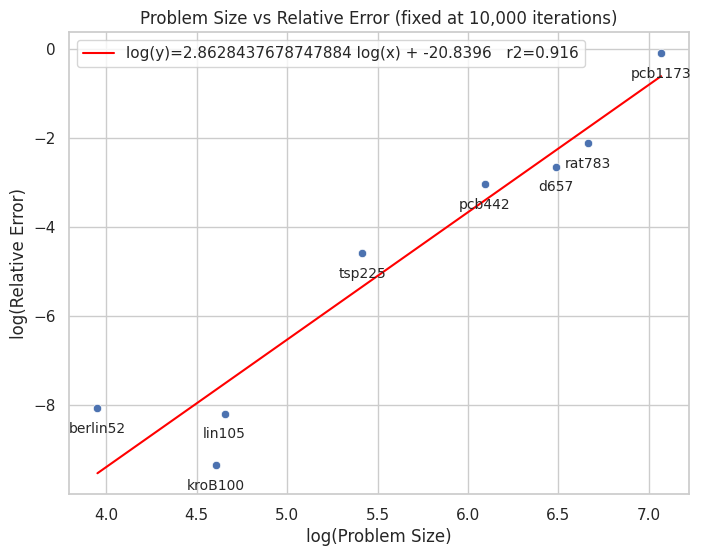

In [10]:
# linear in log-log space suggests power-law (error proportional to problem size)
curve_to_fit = lambda x, a, b: a*x + b

x = 'problem_size'
y = 'relative_error'
xdata = np.log(df[x])
ydata = np.log(df[y])
func_popt, _ = curve_fit(curve_to_fit, xdata, ydata)
x_fit = np.linspace(xdata.min(), xdata.max(), 100)
y_fit = curve_to_fit(x_fit, *func_popt)

r2 = r2_score(ydata,[curve_to_fit(it, *func_popt) for it in xdata])

plt.figure(figsize=(8,6))
sns.scatterplot(x=xdata, y=ydata)
for i in range(len(xdata)):
    plt.text(xdata[i], ydata[i]-0.3, df['problems'][i], fontsize=10, ha='center', va='top')
plt.plot(x_fit, y_fit, label=f"log(y)={func_popt[0]} log(x) + {func_popt[1]:.4f}   r2={r2:.3f}", color="red")
plt.xlabel('log(Problem Size)')
plt.ylabel('log(Relative Error)')
plt.title('Problem Size vs Relative Error (fixed at 10,000 iterations)')
plt.legend()
plt.grid(True)
plt.show()

This implies that the GPU solver's maximum-effort relative error grows
at a rate of about $n^{2.86}$ with respect to problem size 
if we fix the numer of iterations at 10,000.

This in turn suggests that if we want to get the same
accuracy, we must scale the number of iterations by
about
$$\left(\frac{n_{new}}{n_{known}}\right)^{2.86}$$

That being said, the scaling factor ($\sim e^{-21}$) is remarkably small, so this
may work particularly well for small to medium datasets.

## Problem Size vs Average Execution Time

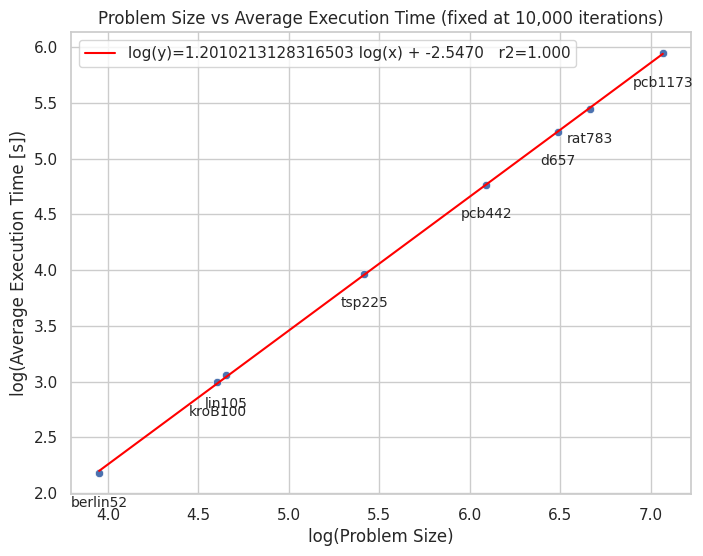

In [11]:
# linear in log-log space suggests power-law (error proportional to problem size)
curve_to_fit = lambda x, a, b: a*x + b

x = 'problem_size'
y = 'average_time'
xdata = np.log(df[x])
ydata = np.log(df[y])
func_popt, _ = curve_fit(curve_to_fit, xdata, ydata)
x_fit = np.linspace(xdata.min(), xdata.max(), 100)
y_fit = curve_to_fit(x_fit, *func_popt)

r2 = r2_score(ydata,[curve_to_fit(it, *func_popt) for it in xdata])

plt.figure(figsize=(8,6))
sns.scatterplot(x=xdata, y=ydata)
for i in range(len(xdata)):
    plt.text(xdata[i], ydata[i]-0.2, df['problems'][i], fontsize=10, ha='center', va='top')
plt.plot(x_fit, y_fit, label=f"log(y)={func_popt[0]} log(x) + {func_popt[1]:.4f}   r2={r2:.3f}", color="red")
plt.xlabel('log(Problem Size)')
plt.ylabel('log(Average Execution Time [s])')
plt.title('Problem Size vs Average Execution Time (fixed at 10,000 iterations)')
plt.legend()
plt.grid(True)
plt.show()

This implies that on a maximum-effort run, the
execution time scales approximately as $O(n^{1.2})$,
at least for 10,000 iterations.

## Problem Size vs Stdev Execution Time

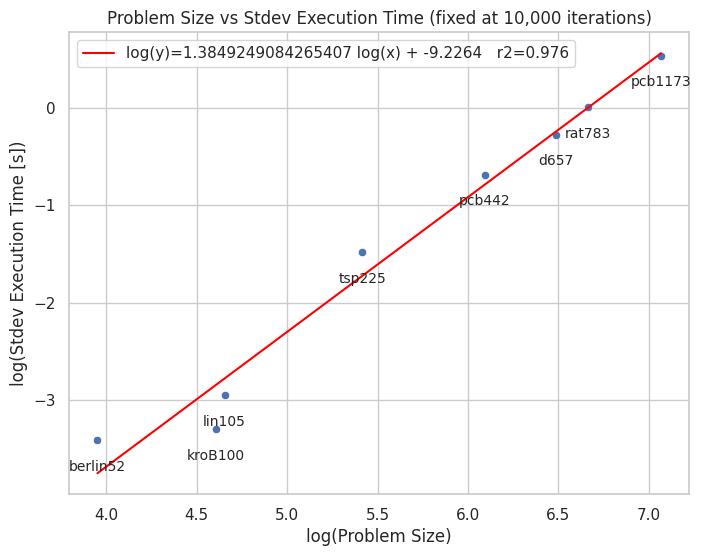

In [12]:
# linear in log-log space suggests power-law (error proportional to problem size)
curve_to_fit = lambda x, a, b: a*x + b

x = 'problem_size'
y = 'stdev_time'
xdata = np.log(df[x])
ydata = np.log(df[y])
func_popt, _ = curve_fit(curve_to_fit, xdata, ydata)
x_fit = np.linspace(xdata.min(), xdata.max(), 100)
y_fit = curve_to_fit(x_fit, *func_popt)

r2 = r2_score(ydata,[curve_to_fit(it, *func_popt) for it in xdata])

plt.figure(figsize=(8,6))
sns.scatterplot(x=xdata, y=ydata)
for i in range(len(xdata)):
    plt.text(xdata[i], ydata[i]-0.2, df['problems'][i], fontsize=10, ha='center', va='top')
plt.plot(x_fit, y_fit, label=f"log(y)={func_popt[0]} log(x) + {func_popt[1]:.4f}   r2={r2:.3f}", color="red")
plt.xlabel('log(Problem Size)')
plt.ylabel('log(Stdev Execution Time [s])')
plt.title('Problem Size vs Stdev Execution Time (fixed at 10,000 iterations)')
plt.legend()
plt.grid(True)
plt.show()

This implies that on a maximum-effort run, the
(sample) standard deviation of the execution time
scales approximately as $O(n^{1.38})$,
at least for 10,000 iterations.

This means that as the problem size increases, the
range of time expected will keep growing, and it will
become harder to predict how much time will be required
even if we fix the number of executions.

That being said, for this problem scale, the deviation is
around 2 seconds at most, so in practice, it's not expected
for it to be an issue, given that the scaling factor is rather
small, at about $e^{-9}$.

## Problem Size vs Normalized Cost Stdev

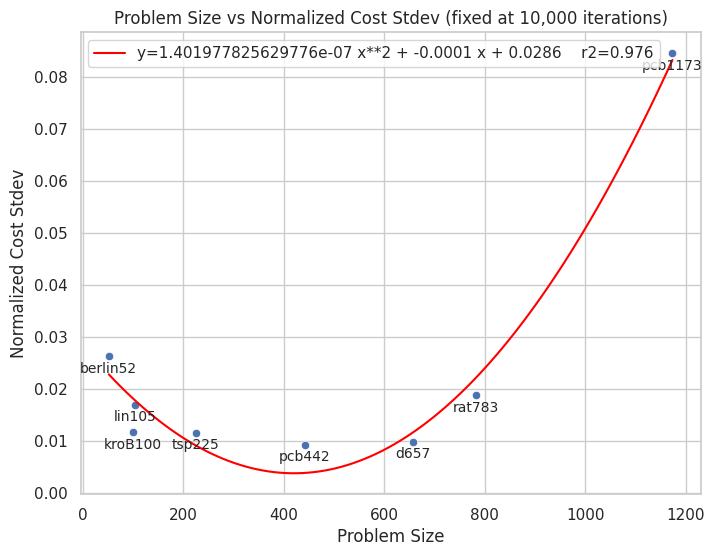

In [13]:
curve_to_fit = lambda x, a, b, c: a*x*x + b*x + c

x = 'problem_size'
y = 'stdev_scaled_cost'
xdata = df[x]
ydata = df[y]
func_popt, _ = curve_fit(curve_to_fit, xdata, ydata)
x_fit = np.linspace(xdata.min(), xdata.max(), 100)
y_fit = curve_to_fit(x_fit, *func_popt)

r2 = r2_score(ydata,[curve_to_fit(it, *func_popt) for it in xdata])

plt.figure(figsize=(8,6))
sns.scatterplot(x=xdata, y=ydata)
for i in range(len(xdata)):
    plt.text(xdata[i], ydata[i]-0.001, df['problems'][i], fontsize=10, ha='center', va='top')
plt.plot(x_fit, y_fit, label=f"y={func_popt[0]} x**2 + {func_popt[1]:.4f} x + {func_popt[2]:.4f}    r2={r2:.3f}", color="red")
plt.xlabel('Problem Size')
plt.ylabel('Normalized Cost Stdev')
plt.title('Problem Size vs Normalized Cost Stdev (fixed at 10,000 iterations)')
plt.legend()
plt.grid(True)
plt.show()

This behaviour is rather odd, but it may suggest that the
variation between executions is more dependent on the problem
at hand, up to the point where there are not enough executions
to properly explore the search space.

That is, pcb1173 did not get enough iterations to have its search
space properly explored, since the performance of its executions was
somewhat spread out, while the others most likely were explored enough
to the point where their solutions yielded answers near to each other.

That being said, the curve fitting the points above should likely be
be ignored given the reasons above, but it is meant to illustrate the
oddness of the scenario.

# Comparative Analysis of Solvers

Given the known optimums of each problem, we made a formula that gave reasonable cutoff percentages based on the problem size, in order to aid in speeding up the testing environment.

$$ \text{cutoff\_percent}(n) = \left( 1 + \left( 0.01 \text{ round}\left( 1+\log_{10}^2{n} \right) \right) \right) $$
$$ \text{cutoff}(problem;n) = \text{cutoff\_percent}(n) \times \text{optimum}(problem) $$

For the used problem sizes, it gives the following percentages:

In [14]:
optimal_solutions = {
    "berlin52": 7542.0,
    "kroB100":  22141.0,
    "lin105":   14379.0,
    "tsp225":   3919.0,
    "pcb442":   50778.0,
    "d657":     48912.0,
    "rat783":   8806.0,
    "pcb1173":  56892.0
}

cutoff_percent = lambda prob_size : 1 + (0.01 * round(1+math.log10(prob_size)**2))
cutoffs = [cutoff_percent(n) for n in gpu['n']]
df = pd.concat([gpu[['problem', 'n', 'cutoff']], pd.DataFrame({'cutoff%': cutoffs, 'optimum': optimal_solutions.values()})], axis=1)
df

,problem,n,cutoff,cutoff%,optimum
0,berlin52,52,7843.68,1.04,7542.0
1,kroB100,100,23248.05,1.05,22141.0
2,lin105,105,15097.95,1.05,14379.0
3,tsp225,225,4193.33,1.07,3919.0
4,pcb442,442,54840.24,1.08,50778.0
5,d657,657,53314.08,1.09,48912.0
6,rat783,783,9598.54,1.09,8806.0
7,pcb1173,1173,62581.20,1.10,56892.0


## Computing statistics per problem

### Table format

In [15]:
def new_data():
    data = dict()
    data['problems'] = list()
    data['problem_size'] = list() 
    data['best_solution'] = list()
    data['optimal_solution'] = list()
    data['average_time'] = list()
    data['median_time'] = list()
    data['stdev_time'] = list()
    data['average_iters'] = list()
    data['median_iters'] = list()
    data['stdev_iters'] = list()
    data['hit_percent'] = list()
    data['executions_considered'] = list()
    data['executions_total'] = list()
    data['seconds'] = list()
    data['iterations'] = list()
    return data

def make_df(old_df):
    data = new_data()
    for i,row in old_df.iterrows():
        problem_name = row['problem']
        cutoff = cutoff_percent(row['n']) * optimal_solutions[problem_name]
        valid_idx = set([idx for idx,x in enumerate(row['costs']) if x <= cutoff])
        seconds = [x for idx,x in enumerate(row['seconds']) if idx in valid_idx]
        iterations = [x for idx,x in enumerate(row['iterations']) if idx in valid_idx]
        
        data['problems'].append(problem_name)
        data['problem_size'].append(row['n'])
        data['best_solution'].append(row['best_solution_cost'])
        data['optimal_solution'].append(optimal_solutions[problem_name])
        data['average_time'].append(sum(seconds)/len(seconds))
        data['median_time'].append(sorted(seconds)[len(seconds)//2])
        data['stdev_time'].append(statistics.stdev(seconds))
        data['average_iters'].append(sum(iterations)/len(iterations))
        data['median_iters'].append(sorted(iterations)[len(iterations)//2])
        data['stdev_iters'].append(statistics.stdev(iterations))
        data['hit_percent'].append(row['hit_percent'])
        data['executions_considered'].append(len(valid_idx))
        data['executions_total'].append(len(row['costs']))
        data['seconds'].append(seconds)
        data['iterations'].append(iterations)
    df = pd.DataFrame(data).sort_values('problem_size')
    return df

### Sequential CPU Solver Statistics

In [16]:
cpuseq_ = make_df(cpuseq)
cpuseq_

,problems,problem_size,best_solution,optimal_solution,average_time,median_time,stdev_time,average_iters,median_iters,stdev_iters,hit_percent,executions_considered,executions_total,seconds,iterations
0,berlin52,52,7746.858,7542.0,3.818737,0.140589,7.854908,6649.133333,224,13734.127009,0.5,15,30,"[0.1069001, 0.1405886, 1.171773, 0.1005219, 0....","[119, 224, 2021, 152, 107, 172, 51391, 15430, ..."
2,kroB100,100,22895.840,22141.0,6.934246,1.900825,11.580238,7907.481481,2146,13233.346816,0.9,27,30,"[1.568768, 0.735349, 13.81191, 2.511836, 9.924...","[1770, 809, 15823, 2853, 11362, 22265, 655, 50..."
1,lin105,105,14904.200,14379.0,8.897433,0.925693,14.073093,9732.238095,986,15441.684098,0.7,21,30,"[0.9256925, 0.6309617, 0.6700086, 0.4037386, 0...","[986, 660, 701, 412, 474, 493, 4727, 497, 329,..."
3,tsp225,225,4171.670,3919.0,44.233359,32.532320,39.657325,25408.777778,18661,22822.639065,0.9,27,30,"[92.56442, 13.1765, 39.49062, 18.19375, 32.532...","[52617, 7460, 22662, 10339, 18661, 67323, 7008..."


### Parallel CPU Solver Statistics

In [17]:
cpupar_ = make_df(cpupar)
cpupar_

,problems,problem_size,best_solution,optimal_solution,average_time,median_time,stdev_time,average_iters,median_iters,stdev_iters,hit_percent,executions_considered,executions_total,seconds,iterations
0,berlin52,52,7756.733,7542.0,1.005216,0.930068,0.411497,80.555556,70,37.562845,0.600000,18,30,"[0.6027828, 0.9590568, 0.9468649, 0.8067403, 0...","[51, 88, 87, 73, 83, 118, 67, 211, 63, 67, 70,..."
2,kroB100,100,22962.990,22141.0,6.893331,4.158265,13.740653,314.896552,179,674.963245,0.966667,29,30,"[5.289172, 4.299765, 4.565496, 5.783101, 4.846...","[232, 190, 198, 258, 212, 162, 130, 174, 356, ..."
1,lin105,105,14970.280,14379.0,8.699266,4.572434,15.882696,386.000000,191,746.806717,0.766667,23,30,"[5.31679, 4.936025, 81.06734, 4.280106, 3.9811...","[227, 206, 3789, 179, 165, 242, 184, 305, 168,..."
3,tsp225,225,4172.652,3919.0,28.575532,23.504370,21.888167,604.066667,488,492.936167,1.000000,30,30,"[22.69705, 20.57119, 23.94737, 28.04287, 21.12...","[477, 432, 498, 587, 439, 490, 488, 436, 469, ..."


### GPU Solver Statistics

In [18]:
gpu_ = make_df(gpu)
gpu_

,problems,problem_size,best_solution,optimal_solution,average_time,median_time,stdev_time,average_iters,median_iters,stdev_iters,hit_percent,executions_considered,executions_total,seconds,iterations
0,berlin52,52,7621.701,7542.0,9.397063,0.146158,33.187314,10793.414634,150,38199.410245,0.82,41,50,"[0.1369323, 0.1822764, 0.1326012, 0.1715166, 0...","[141, 191, 135, 178, 116, 108, 172, 144, 1594,..."
1,kroB100,100,23054.690,22141.0,1.322515,0.998241,1.592549,645.280000,481,805.862880,1.00,50,50,"[0.9255996, 1.00016, 0.8809739, 1.255852, 0.94...","[445, 484, 420, 608, 455, 417, 482, 423, 501, ..."
2,lin105,105,14736.310,14379.0,3.850169,1.134760,12.048825,1799.420000,513,5705.083544,1.00,50,50,"[1.162428, 1.067089, 1.09791, 0.9643656, 1.970...","[524, 483, 496, 435, 909, 641, 489, 588, 412, ..."
3,tsp225,225,4166.302,3919.0,10.081372,9.841452,1.641610,1864.960000,1819,309.633685,1.00,50,50,"[7.38594, 9.753932, 9.30713, 9.862912, 8.16254...","[1356, 1802, 1719, 1825, 1506, 1772, 1773, 161..."
4,pcb442,442,54691.970,50778.0,107.897629,77.108370,126.687849,9106.560000,6492,10826.196517,1.00,50,50,"[84.44571, 71.97059, 102.545, 64.98933, 65.740...","[7058, 5984, 8542, 5387, 5447, 6701, 6459, 732..."
5,d657,657,53150.820,48912.0,192.890604,187.205400,24.546202,10217.660000,9900,1313.549104,1.00,50,50,"[246.321, 157.5343, 197.0602, 192.1078, 178.33...","[13082, 8334, 10445, 10193, 9439, 10040, 13458..."
6,rat783,783,9588.249,8806.0,393.283610,380.958400,79.179456,17066.400000,16470,3434.067333,1.00,50,50,"[400.9437, 449.0737, 359.8752, 410.203, 379.59...","[17373, 19476, 15629, 17780, 16450, 16553, 252..."
7,pcb1173,1173,62503.390,56892.0,1554.041451,1436.482000,625.047320,41166.020408,37904,16729.369289,0.98,49,50,"[1218.816, 1021.09, 1098.758, 1251.291, 1490.2...","[32236, 26943, 28934, 33143, 39503, 28489, 390..."


## Speedup (seconds)

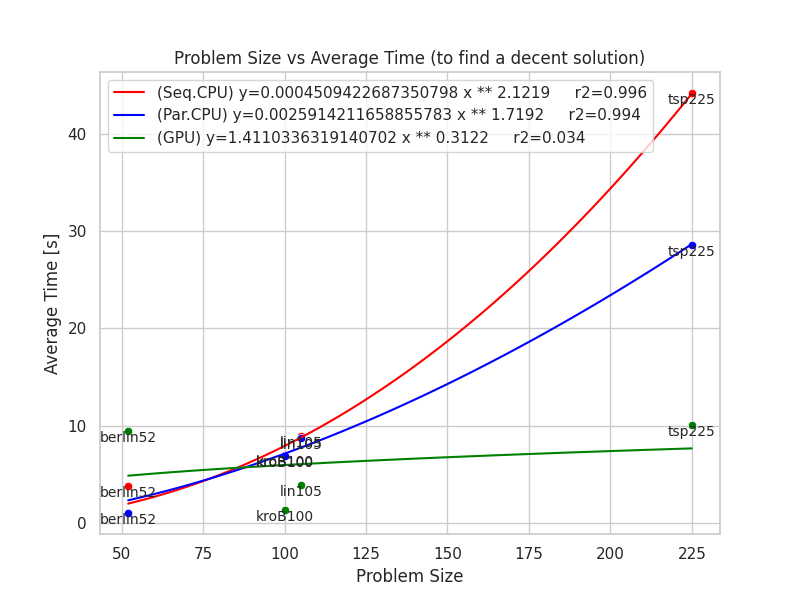

In [19]:
curve_to_fit = lambda x, a, b: a*np.pow(x,b)

x = 'problem_size'
y = 'average_time'
plt.figure(figsize=(8,6))

maxlen = min(len(cpuseq_), len(cpupar_), len(gpu_))
for df, color, solv in [(cpuseq_, 'red', 'Seq.CPU'), (cpupar_, 'blue', 'Par.CPU'), (gpu_, 'green', 'GPU')]:
    df = df[:maxlen]
    xdata = df[x]
    ydata = df[y]
    func_popt, _ = curve_fit(curve_to_fit, xdata, ydata)
    x_fit = np.linspace(xdata.min(), xdata.max(), 100)
    y_fit = curve_to_fit(x_fit, *func_popt)
    
    r2 = r2_score(ydata,[curve_to_fit(it, *func_popt) for it in xdata])

    sns.scatterplot(x=xdata, y=ydata, color=color)
    plt.plot(x_fit, y_fit, label=f"({solv}) y={func_popt[0]} x ** {func_popt[1]:.4f}     r2={r2:.3f}", color=color)
    for i in range(len(xdata)):
        plt.text(xdata[i], ydata[i]-0.001, df['problems'][i], fontsize=10, ha='center', va='top')

plt_name = 'Problem Size vs Average Time (to find a decent solution)'
plt.xlabel('Problem Size')
plt.ylabel('Average Time [s]')
plt.title(plt_name)
plt.legend()
plt.grid(True)
save_plt(plt_name)
display_saved_plt(plt_name)

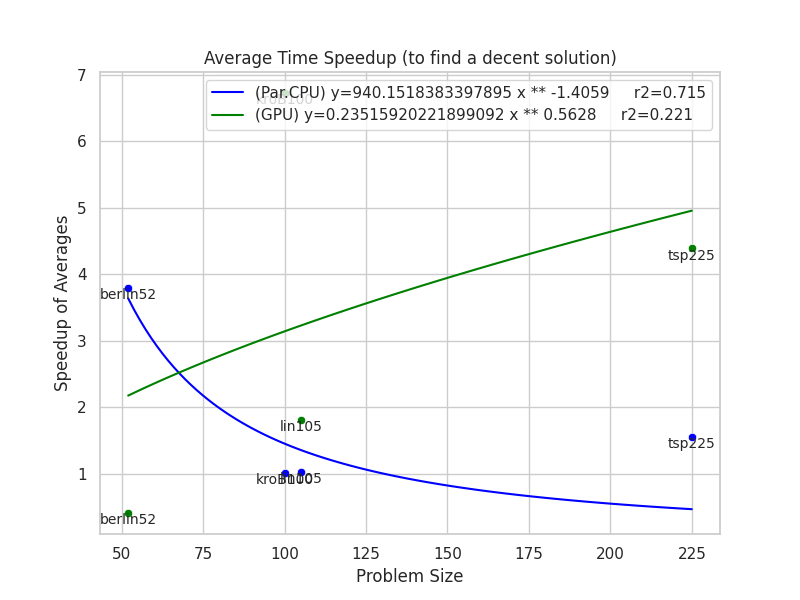

In [20]:
curve_to_fit = lambda x, a, b: a*np.pow(x,b)

x = 'problem_size'
y = 'average_time'
plt.figure(figsize=(8,6))

maxlen = min(len(cpuseq_), len(cpupar_), len(gpu_))
for df, color, solv in [(cpupar_, 'blue', 'Par.CPU'), (gpu_, 'green', 'GPU')]:
    df = df[:maxlen]
    xdata = df[x]
    ydata = cpuseq_[y] / df[y]
    func_popt, _ = curve_fit(curve_to_fit, xdata, ydata)
    x_fit = np.linspace(xdata.min(), xdata.max(), 100)
    y_fit = curve_to_fit(x_fit, *func_popt)
    
    r2 = r2_score(ydata,[curve_to_fit(it, *func_popt) for it in xdata])

    sns.scatterplot(x=xdata, y=ydata, color=color)
    plt.plot(x_fit, y_fit, label=f"({solv}) y={func_popt[0]} x ** {func_popt[1]:.4f}     r2={r2:.3f}", color=color)
    for i in range(len(xdata)):
        plt.text(xdata[i], ydata[i]-0.001, df['problems'][i], fontsize=10, ha='center', va='top')

plt_name = 'Average Time Speedup (to find a decent solution)'
plt.xlabel('Problem Size')
plt.ylabel('Speedup of Averages')
plt.title(plt_name)
plt.legend()
plt.grid(True)
save_plt(plt_name)
display_saved_plt(plt_name)

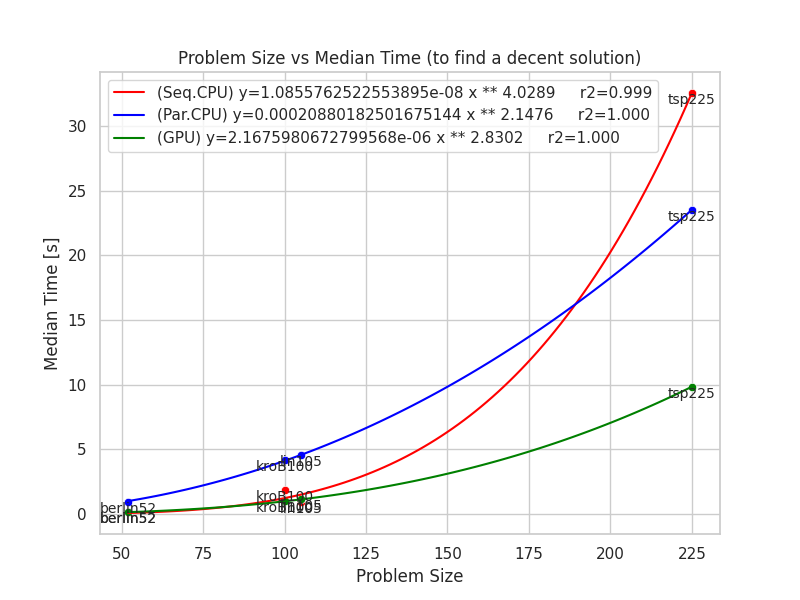

In [21]:
curve_to_fit = lambda x, a, b: a*np.pow(x,b)

x = 'problem_size'
y = 'median_time'
plt.figure(figsize=(8,6))

maxlen = min(len(cpuseq_), len(cpupar_), len(gpu_))
for df, color, solv in [(cpuseq_, 'red', 'Seq.CPU'), (cpupar_, 'blue', 'Par.CPU'), (gpu_, 'green', 'GPU')]:
    df = df[:maxlen]
    xdata = df[x]
    ydata = df[y]
    func_popt, _ = curve_fit(curve_to_fit, xdata, ydata)
    x_fit = np.linspace(xdata.min(), xdata.max(), 100)
    y_fit = curve_to_fit(x_fit, *func_popt)
    
    r2 = r2_score(ydata,[curve_to_fit(it, *func_popt) for it in xdata])

    sns.scatterplot(x=xdata, y=ydata, color=color)
    plt.plot(x_fit, y_fit, label=f"({solv}) y={func_popt[0]} x ** {func_popt[1]:.4f}     r2={r2:.3f}", color=color)
    for i in range(len(xdata)):
        plt.text(xdata[i], ydata[i]-0.001, df['problems'][i], fontsize=10, ha='center', va='top')

plt_name = 'Problem Size vs Median Time (to find a decent solution)'
plt.xlabel('Problem Size')
plt.ylabel('Median Time [s]')
plt.title(plt_name)
plt.legend()
plt.grid(True)
save_plt(plt_name)
display_saved_plt(plt_name)

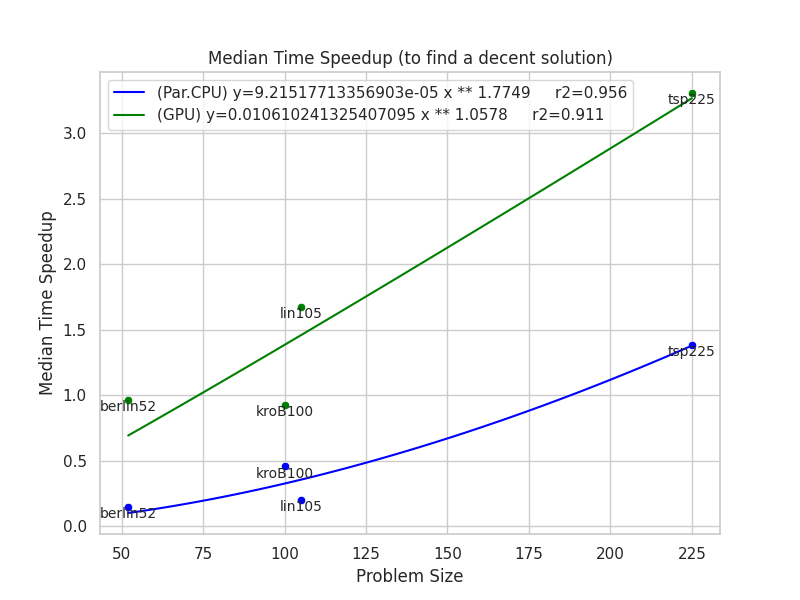

In [22]:
curve_to_fit = lambda x, a, b: a*np.pow(x,b)

x = 'problem_size'
y = 'median_time'
plt.figure(figsize=(8,6))

maxlen = min(len(cpuseq_), len(cpupar_), len(gpu_))
for df, color, solv in [(cpupar_, 'blue', 'Par.CPU'), (gpu_, 'green', 'GPU')]:
    df = df[:maxlen]
    xdata = df[x]
    ydata = cpuseq_[y]/df[y]
    func_popt, _ = curve_fit(curve_to_fit, xdata, ydata)
    x_fit = np.linspace(xdata.min(), xdata.max(), 100)
    y_fit = curve_to_fit(x_fit, *func_popt)
    
    r2 = r2_score(ydata,[curve_to_fit(it, *func_popt) for it in xdata])

    sns.scatterplot(x=xdata, y=ydata, color=color)
    plt.plot(x_fit, y_fit, label=f"({solv}) y={func_popt[0]} x ** {func_popt[1]:.4f}     r2={r2:.3f}", color=color)
    for i in range(len(xdata)):
        plt.text(xdata[i], ydata[i]-0.001, df['problems'][i], fontsize=10, ha='center', va='top')

plt_name = 'Median Time Speedup (to find a decent solution)'
plt.xlabel('Problem Size')
plt.ylabel('Median Time Speedup')
plt.title(plt_name)
plt.legend()
plt.grid(True)
save_plt(plt_name)
display_saved_plt(plt_name)

## Speedup (iterations)

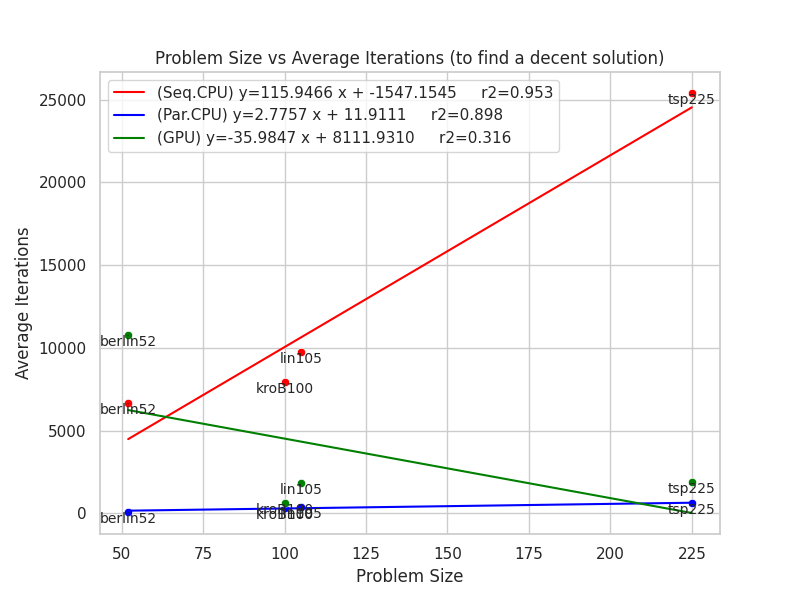

In [23]:
curve_to_fit = lambda x, a, b: a*x + b

x = 'problem_size'
y = 'average_iters'
plt.figure(figsize=(8,6))

maxlen = min(len(cpuseq_), len(cpupar_), len(gpu_))
for df, color, solv in [(cpuseq_, 'red', 'Seq.CPU'), (cpupar_, 'blue', 'Par.CPU'), (gpu_, 'green', 'GPU')]:
    df = df[:maxlen]
    xdata = df[x]
    ydata = df[y]
    func_popt, _ = curve_fit(curve_to_fit, xdata, ydata)
    x_fit = np.linspace(xdata.min(), xdata.max(), 100)
    y_fit = curve_to_fit(x_fit, *func_popt)
    
    r2 = r2_score(ydata,[curve_to_fit(it, *func_popt) for it in xdata])

    sns.scatterplot(x=xdata, y=ydata, color=color)
    plt.plot(x_fit, y_fit, label=f"({solv}) y={func_popt[0]:.4f} x + {func_popt[1]:.4f}     r2={r2:.3f}", color=color)
    for i in range(len(xdata)):
        plt.text(xdata[i], ydata[i]-0.001, df['problems'][i], fontsize=10, ha='center', va='top')

plt_name = 'Problem Size vs Average Iterations (to find a decent solution)'
plt.xlabel('Problem Size')
plt.ylabel('Average Iterations')
plt.title(plt_name)
plt.legend()
plt.grid(True)
save_plt(plt_name)
display_saved_plt(plt_name)

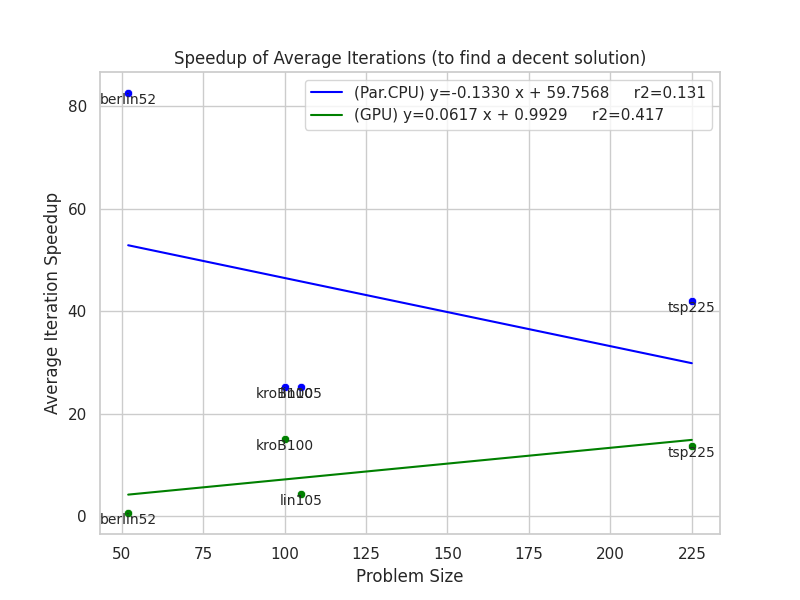

In [24]:
curve_to_fit = lambda x, a, b: a*x + b

x = 'problem_size'
y = 'average_iters'
plt.figure(figsize=(8,6))

maxlen = min(len(cpuseq_), len(cpupar_), len(gpu_))
for df, color, solv in [(cpupar_, 'blue', 'Par.CPU'), (gpu_, 'green', 'GPU')]:
    df = df[:maxlen]
    xdata = df[x]
    ydata = cpuseq_[y]/df[y]
    func_popt, _ = curve_fit(curve_to_fit, xdata, ydata)
    x_fit = np.linspace(xdata.min(), xdata.max(), 100)
    y_fit = curve_to_fit(x_fit, *func_popt)
    
    r2 = r2_score(ydata,[curve_to_fit(it, *func_popt) for it in xdata])

    sns.scatterplot(x=xdata, y=ydata, color=color)
    plt.plot(x_fit, y_fit, label=f"({solv}) y={func_popt[0]:.4f} x + {func_popt[1]:.4f}     r2={r2:.3f}", color=color)
    for i in range(len(xdata)):
        plt.text(xdata[i], ydata[i]-0.001, df['problems'][i], fontsize=10, ha='center', va='top')

plt_name = 'Speedup of Average Iterations (to find a decent solution)'
plt.xlabel('Problem Size')
plt.ylabel('Average Iteration Speedup')
plt.title(plt_name)
plt.legend()
plt.grid(True)
save_plt(plt_name)
display_saved_plt(plt_name)

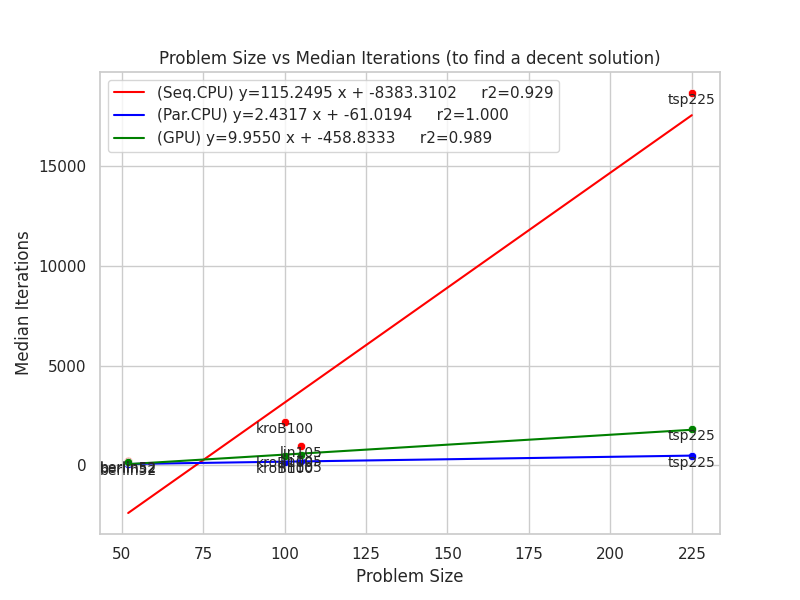

In [25]:
curve_to_fit = lambda x, a, b: a*x + b

x = 'problem_size'
y = 'median_iters'
plt.figure(figsize=(8,6))

maxlen = min(len(cpuseq_), len(cpupar_), len(gpu_))
for df, color, solv in [(cpuseq_, 'red', 'Seq.CPU'), (cpupar_, 'blue', 'Par.CPU'), (gpu_, 'green', 'GPU')]:
    df = df[:maxlen]
    xdata = df[x]
    ydata = df[y]
    func_popt, _ = curve_fit(curve_to_fit, xdata, ydata)
    x_fit = np.linspace(xdata.min(), xdata.max(), 100)
    y_fit = curve_to_fit(x_fit, *func_popt)
    
    r2 = r2_score(ydata,[curve_to_fit(it, *func_popt) for it in xdata])

    sns.scatterplot(x=xdata, y=ydata, color=color)
    plt.plot(x_fit, y_fit, label=f"({solv}) y={func_popt[0]:.4f} x + {func_popt[1]:.4f}     r2={r2:.3f}", color=color)
    for i in range(len(xdata)):
        plt.text(xdata[i], ydata[i]-0.001, df['problems'][i], fontsize=10, ha='center', va='top')

plt_name = 'Problem Size vs Median Iterations (to find a decent solution)'
plt.xlabel('Problem Size')
plt.ylabel('Median Iterations')
plt.title(plt_name)
plt.legend()
plt.grid(True)
save_plt(plt_name)
display_saved_plt(plt_name)

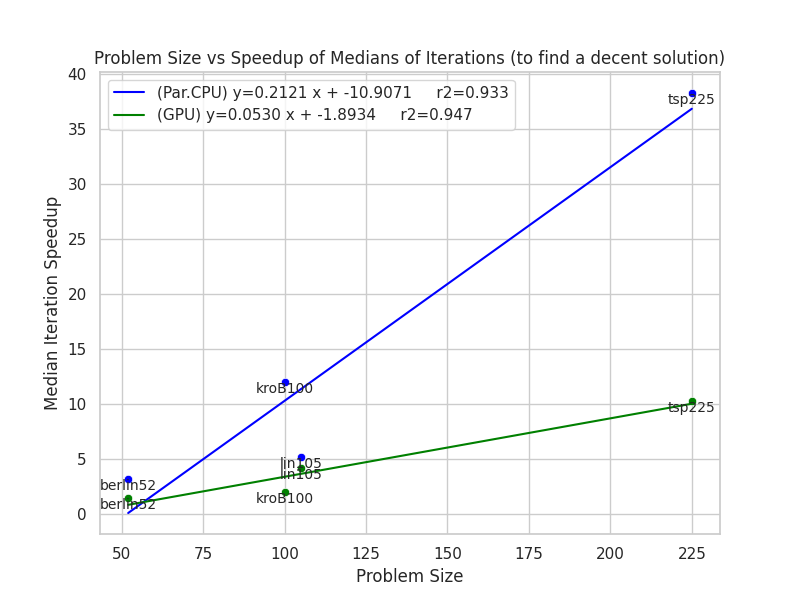

In [26]:
curve_to_fit = lambda x, a, b: a*x + b

x = 'problem_size'
y = 'median_iters'
plt.figure(figsize=(8,6))

maxlen = min(len(cpuseq_), len(cpupar_), len(gpu_))
for df, color, solv in [(cpupar_, 'blue', 'Par.CPU'), (gpu_, 'green', 'GPU')]:
    df = df[:maxlen]
    xdata = df[x]
    ydata = cpuseq_[y]/df[y]
    func_popt, _ = curve_fit(curve_to_fit, xdata, ydata)
    x_fit = np.linspace(xdata.min(), xdata.max(), 100)
    y_fit = curve_to_fit(x_fit, *func_popt)
    
    r2 = r2_score(ydata,[curve_to_fit(it, *func_popt) for it in xdata])

    sns.scatterplot(x=xdata, y=ydata, color=color)
    plt.plot(x_fit, y_fit, label=f"({solv}) y={func_popt[0]:.4f} x + {func_popt[1]:.4f}     r2={r2:.3f}", color=color)
    for i in range(len(xdata)):
        plt.text(xdata[i], ydata[i]-0.001, df['problems'][i], fontsize=10, ha='center', va='top')

plt_name = 'Problem Size vs Speedup of Medians of Iterations (to find a decent solution)'
plt.xlabel('Problem Size')
plt.ylabel('Median Iteration Speedup')
plt.title(plt_name)
plt.legend()
plt.grid(True)
save_plt(plt_name)
display_saved_plt(plt_name)

## Summary of Speedups

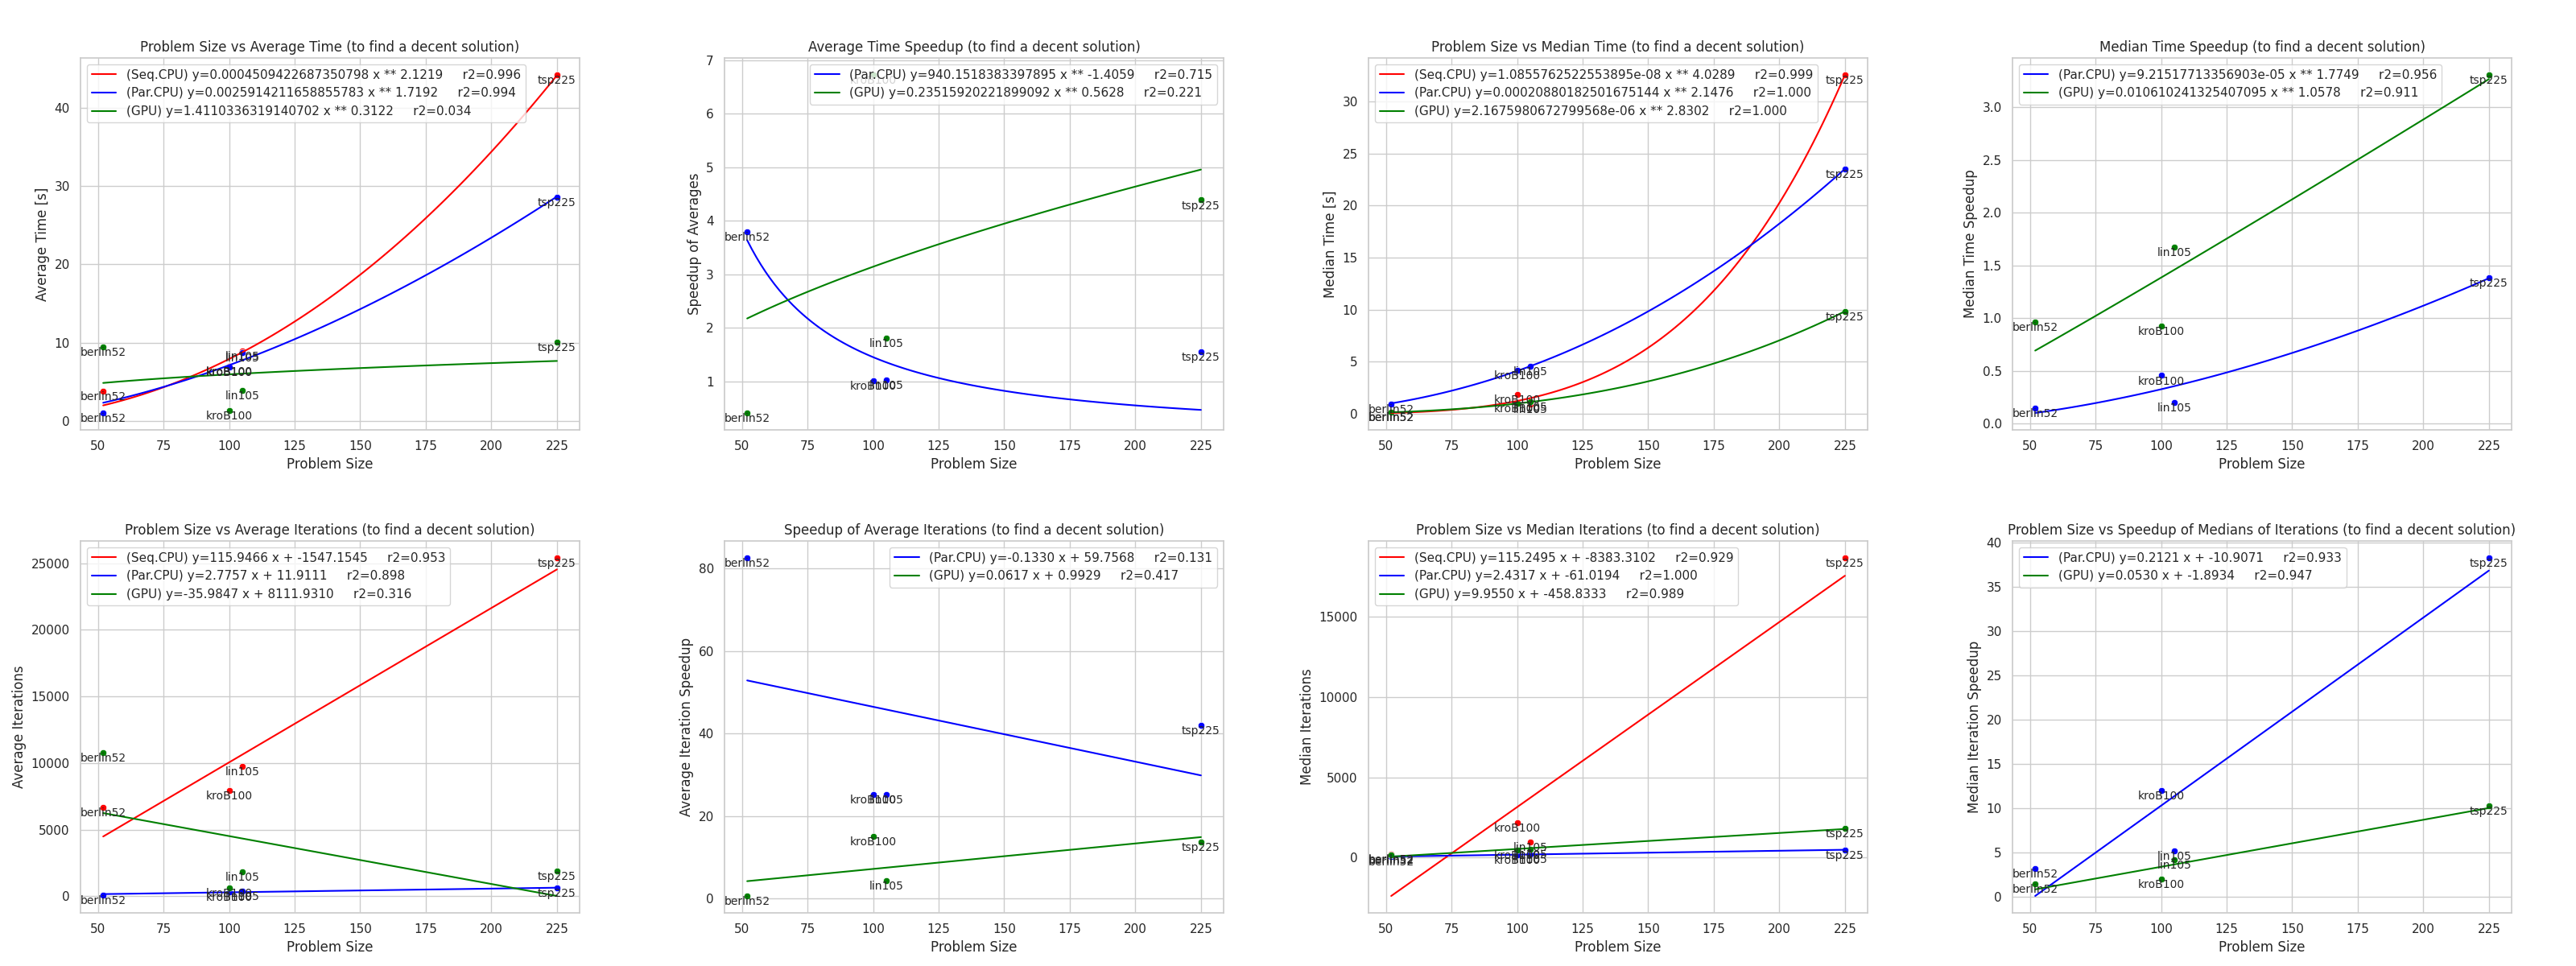

In [27]:
dims = (2,4)
plots=[
    'Problem Size vs Average Time (to find a decent solution)',
    'Average Time Speedup (to find a decent solution)',
    'Problem Size vs Median Time (to find a decent solution)',
    'Median Time Speedup (to find a decent solution)',

    'Problem Size vs Average Iterations (to find a decent solution)',
    'Speedup of Average Iterations (to find a decent solution)',
    'Problem Size vs Median Iterations (to find a decent solution)',
    'Problem Size vs Speedup of Medians of Iterations (to find a decent solution)'
]
cached_mosaic(plots, dims)

We can see that we get a very reasonable time speedup for the parallel CPU version, not too far away from the number of physical cores with the exception of the average time. We found for our problem sizes execution time to be very hard to correlate with any particular function with respect to problem size, which indicates that it may be more closely related to the problem in particular at this scale.

Where we got more consistent results was when we studied the median time and iteration count, where we got superlinear speedups. This indicates that if we were to tweak the program, especially the parallel CPU code, to take about the same time per iteration, that we might see superlinear timing speedups as well.

All this should be taken to mean that with out parallel CPU implemention, more cores means faster convergence (round-wise) to a good candidate solution.

We found less success with our GPU implementation, possibly due to the more restricted population sizes and higher reliance on having a lot of populations, at the expense of them being smaller.

This also suggests that it might be worth investigating into reducing GPU-CPU communication and optimizing execution for lower city-counts, since the parallel efficiency is remarkably low. We should be expecting speedups in the order of a few hundreds at the very least, given that we're using over a thousand more cores.